In [8]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.models import Model

In [9]:
train_dir = "archive/train/"
test_dir = "archive/test"
valid_dir ='archive/valid'

Found 0 images in directory: archive/train/
Found 1569 images in directory: archive/train/0
Found 803 images in directory: archive/train/1


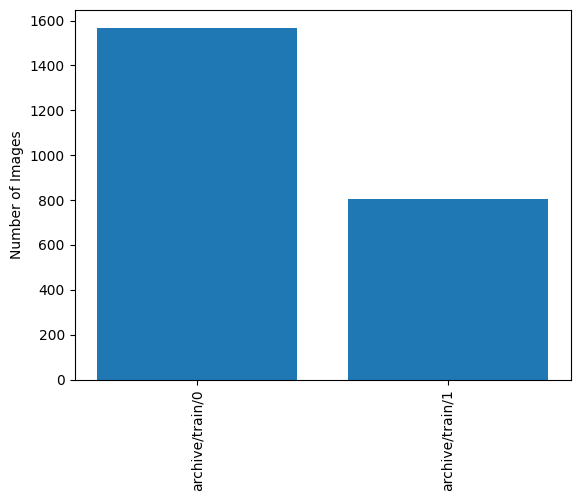

In [10]:
num_images = 0

for dirpath, dirnames, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.lower().endswith(('.jpg')):
            num_images += 1

    print(f"Found {num_images} images in directory: {dirpath}")
    num_images = 0


subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

In [11]:
minority_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2,
        rotation_range=10,
        brightness_range=(0,10),
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest',

)

main_train_gen = ImageDataGenerator(rescale=1./255)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
minority_class_directory = 'archive/train/1'

minority_class_generator = minority_train_gen.flow_from_directory(
    directory=minority_class_directory,
    target_size=(320,320),
    batch_size=20,
    class_mode='binary',
    shuffle=True,
)

main_generator = main_train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(320, 320),
    batch_size=20,
    class_mode='binary',
    shuffle=True,
)

Found 0 images belonging to 0 classes.
Found 2372 images belonging to 2 classes.


In [13]:
"""
train_images = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(320,320),
        batch_size=20,
        shuffle=True,
        seed=42,
)
"""
val_images = main_train_gen.flow_from_directory(
        directory=valid_dir,
        target_size=(320,320),
        class_mode='binary',
        shuffle=True,
)
test_images = test_gen.flow_from_directory(
        directory=test_dir,
        target_size=(320,320),
        class_mode='binary',
        batch_size=1,
        shuffle=False,
)

Found 818 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [14]:
class_names = os.listdir('archive/train')
print(f"Class names: {class_names}")

Class names: ['0', '1']


In [15]:
images, labels = next(val_images)

print("Shape of images: ", images.shape)
print("Labels", labels.shape)

Shape of images:  (32, 320, 320, 3)
Labels (32,)


Text(0.5, 1.0, '1')

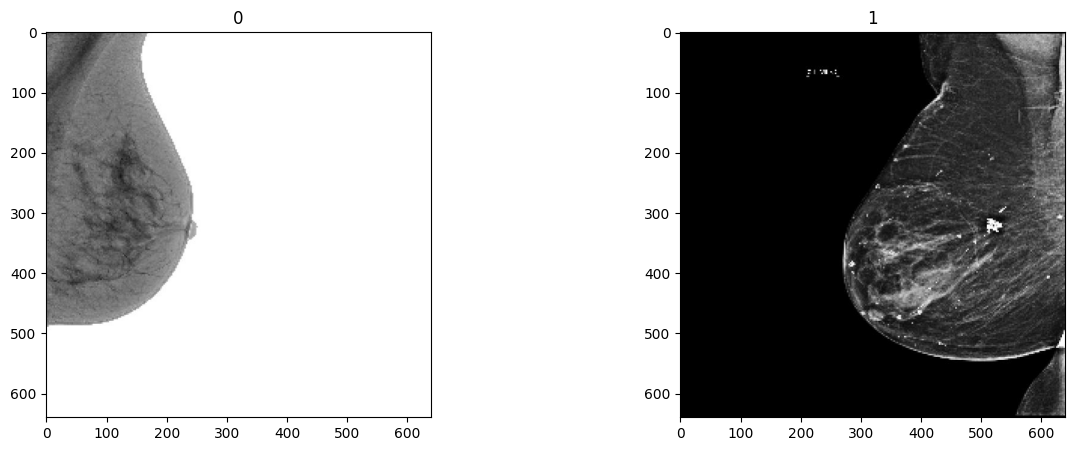

In [16]:
plt.figure(1, figsize = (15 , 5))
plt.subplot(1, 2 , 1)
plt.imshow(cv2.imread('archive/train/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg'))
plt.title('0')



plt.figure(1, figsize = (15 , 5))
plt.subplot(1, 2 , 2)
plt.imshow(cv2.imread('archive/train/1/10130_1672636630_png.rf.52c6d1c8c6c58c5c1c5fcaaf57feb81d.jpg'))
plt.title('1')


In [17]:
pretrained_model = tf.keras.applications.ResNet101(
    input_shape=(320, 320, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False


inputs = pretrained_model.input

layer1 = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
layer2 = tf.keras.layers.BatchNormalization()(layer1)
layer3 = tf.keras.layers.Dropout(0.4)(layer2)

layer4 = tf.keras.layers.Dense(512, activation='relu')(layer3)
layer5 = tf.keras.layers.BatchNormalization()(layer4)
layer6 = tf.keras.layers.Dropout(0.3)(layer5)

layer7 = tf.keras.layers.Dense(256, activation='relu')(layer6)
layer8 = tf.keras.layers.BatchNormalization()(layer7)
layer9 = tf.keras.layers.Dropout(0.2)(layer8)

outputs = tf.keras.layers.Dense(525, activation='softmax')(layer9)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


I0000 00:00:1731954629.229022  851805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731954629.251796  851805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731954629.253006  851805 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731954629.258143  851805 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 326, 326,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 160, 160,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 162, 162,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 80, 80,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 80, 80,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 80, 80,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 80, 80,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 80, 80,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 80, 80,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 80, 80,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 80, 80,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 80, 80,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_3_c

 Total params: 45,555,099 (173.78 MB)

 Trainable params: 2,893,339 (11.04 MB)

 Non-trainable params: 42,661,760 (162.74 MB)

In [19]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [20]:
def balanced_generator(main_gen, minority_gen):
    while True:
        main_images, main_labels = next(main_gen)
        
        minority_images, minority_labels = next(minority_gen)
        
        combined_images = np.concatenate((main_images, minority_images), axis=0)
        combined_labels = np.concatenate((main_labels, minority_labels), axis=0)
        
        yield combined_images, combined_labels

history = model.fit(
    balanced_generator(main_generator, minority_class_generator),
    validation_data=val_images,
    epochs=5,
    steps_per_epoch=400,    # Adjust this based on your dataset size

)

Epoch 1/5


I0000 00:00:1731954642.045053  861517 service.cc:146] XLA service 0x7145e8002a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731954642.045072  861517 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-19 00:00:42.272776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-19 00:00:43.521595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1731954650.325537  861517 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 149s 327ms/step - accuracy: 0.6553 - loss: 0.6673 - val_accuracy: 0.5477 - val_loss: 0.6911
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 109s 271ms/step - accuracy: 0.6635 - loss: 0.6295 - val_accuracy: 0.5477 - val_loss: 0.6841
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 108s 271ms/step - accuracy: 0.6613 - loss: 0.6136 - val_accuracy: 0.5575 - val_loss: 0.7399
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 109s 271ms/step - accuracy: 0.6939 - loss: 0.6066 - val_accuracy: 0.5599 - val_loss: 0.7233
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 108s 271ms/step - accuracy: 0.7130 - loss: 0.5879 - val_accuracy: 0.5990 - val_loss: 0.7086


In [14]:
"""history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=200,
    class_weight={0:3, 1:1},
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)"""

"history = model.fit(\n    train_images,\n    validation_data=val_images,\n    epochs=200,\n    class_weight={0:3, 1:1},\n    callbacks=[\n        tf.keras.callbacks.EarlyStopping(\n            monitor='val_loss',\n            patience=12,\n            restore_best_weights=True\n        )\n    ]\n)"

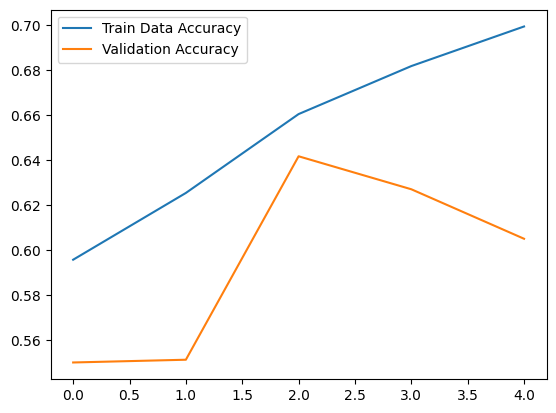

In [24]:
plt.plot(history.history['accuracy'], label = 'Train Data Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(test_images)
print(f'Test accuracy: {test_accuracy}')

413/413 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5109 - loss: 0.7172
Test accuracy: 0.5302663445472717


In [17]:
model.save('transfer_resnet.keras')

In [18]:
model.predict(test_images)


413/413 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step


array([[0.29549116],
       [0.71450025],
       [0.5605195 ],
       [0.60635555],
       [0.29549116],
       [0.2954932 ],
       [0.71449524],
       [0.71395934],
       [0.71450025],
       [0.29549116],
       [0.2955748 ],
       [0.29549116],
       [0.71449965],
       [0.54189056],
       [0.5408457 ],
       [0.71450025],
       [0.29549116],
       [0.29549116],
       [0.2954912 ],
       [0.29614162],
       [0.295501  ],
       [0.29549116],
       [0.5408495 ],
       [0.71450025],
       [0.2954914 ],
       [0.29549116],
       [0.2954914 ],
       [0.71450025],
       [0.5408466 ],
       [0.7144976 ],
       [0.29549134],
       [0.29549116],
       [0.29549116],
       [0.55117863],
       [0.29549116],
       [0.29549116],
       [0.29549485],
       [0.29549116],
       [0.71450025],
       [0.29549116],
       [0.71450025],
       [0.71450025],
       [0.5410051 ],
       [0.6902712 ],
       [0.5409554 ],
       [0.29864192],
       [0.29549214],
       [0.541

In [19]:
predictions = (model.predict(test_images) > 0.38).astype(int).flatten()
print(predictions)

413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
[0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0
 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1
 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1
 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1
 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1
 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1
 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1
 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1
 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 0]


In [20]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
import seaborn as sns

In [21]:
CLASS_NAMES = list(main_generator.class_indices.keys())
predictions = (model.predict(test_images) > 0.5).astype(int).flatten()
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions).numpy()
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
Test Accuracy: 53.027%


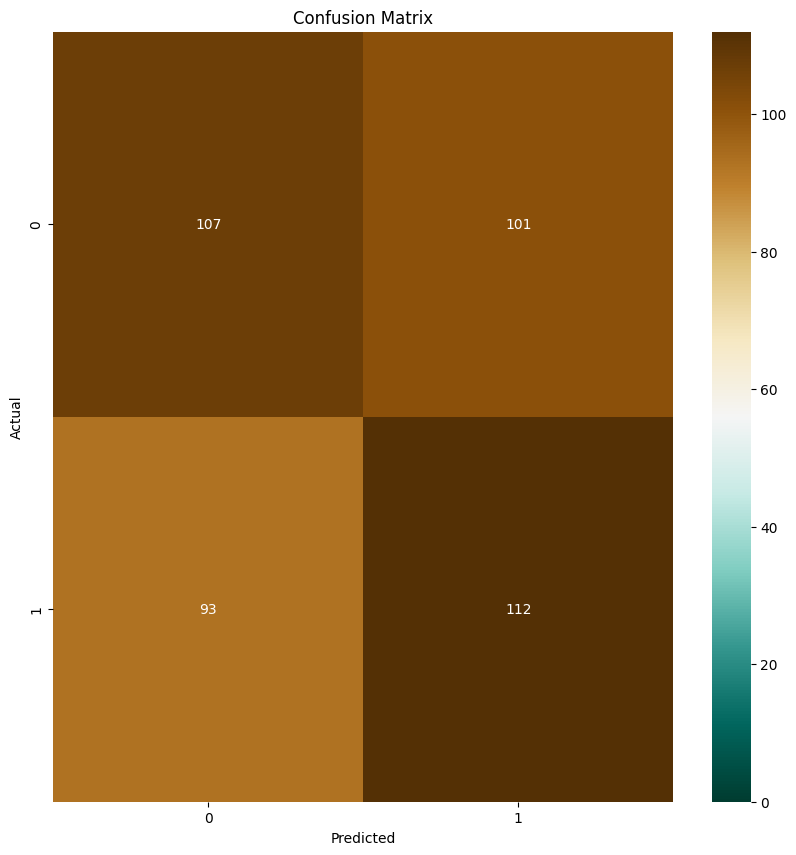

In [22]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True,fmt='d', vmin=0, cmap='BrBG_r', cbar=True)
plt.xticks(ticks= np.arange(2) + 0.5,)
plt.yticks(ticks= np.arange(2) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = test_images.classes
y_pred = predictions

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.53
Recall: 0.55
F1 Score: 0.54
